<center>
<img src="https://camo.githubusercontent.com/ad20aaaa48264581c46aa126919dbb72060ebd98cffe015523549b4974843ae5/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f46556c79616e6b696e2f725f70726f626162696c6974792f6d61737465722f656e645f73656d696e6172732f73656d5f362f73747564656e745f746561636865725f646973742e706e67" height="200"> 

# Прикладаная статистика: домашнее задание 3
</center>

> Если орел — я выиграла, если решка — ты проиграл.

$\qquad$ Рейчел из друзей


**ФИО:**
Герасимов Владислав Евгеньевич

## Общая информация


__Дата выдачи:__ 24.05.2023

__Дедлайн:__ 23:59MSK 11.06.2023

# Результаты A-B теста

В данном задании вам нужно будет проанализировать АБ тест, проведенный на реальных пользователях Яндекса.

### Описание данных:

* `userID` — уникальный идентификатор пользователя
* `browser` — браузер, который использовал userID
* `slot` — в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks` — количество кликов, которые пользоваль совершил за n_queries
* `n_queries` — количество запросов, который совершил userID, пользуясь браузером browser
* `n_nonclk_queries` — количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.weightstats import ztest

In [2]:
df = pd.read_csv('data/ab_browser_test.csv',sep=',')

df['click_per_queries'] = df['n_clicks']/df['n_queries']
df['empty_query_share'] = df['n_nonclk_queries']/df['n_queries']

print(df.shape)
df.head()

(566134, 8)


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19,0.718750,0.593750
1,3,Browser #4,exp,3,4,2,0.750000,0.500000
2,5,Browser #4,exp,29,35,16,0.828571,0.457143
3,6,Browser #4,control,12,6,0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30,0.794118,0.441176


Будем работать с числом кликов на количество пользовательских сессий. 

> Вообще, это ratio-метрика. Из-за этого у неё будут довольно тяжёлые хвосты. Мы увидим это ниже в пункте про бутстрэп. И к ней нужен особый подход, о котором мы поговорим на лекции. Пока что будем это игнорировать. В целом, можно откатиться к кликам и работать с их средним, но методологически правильнее отнормировать их на число сессий.

__[10 баллов]__ Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [3]:
exp_mean = df.loc[df['slot']=='exp', 'click_per_queries'].mean()
control_mean = df.loc[df['slot']=='control', 'click_per_queries'].mean()

print(f'В среднем в тритменте на {(exp_mean / control_mean - 1) * 100:.2f}% больше кликов, чем в контроле')

В среднем в тритменте на 7.49% больше кликов, чем в контроле


Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

## Часть 1: анализ АБ-теста

__[10 баллов]__ Давайте мнимательнее посмотрим на то, что происходит с кликами в наших пользовательских сессиях. Постройте для контрольной и тестовой групп визуализации и ответьте на следующие вопросы.

- Правда ли, что в данных есть много выбросов?
- Правда ли, что данные пришли из одного распределения и в группах отличия только в сдвиге (для ответа на этот вопрос постройте для обеих групп квантили распределений с шагом в 0.1 и сравните их между собой + сравните гистограмы по форме)
- Как думаете, какие тесты применимы здесь для проведения АБ? 

**Ответы:**

- Выбросов правда много
- Мне кажется, это неправда: визуально сдвига не видно, эмперические плотности распределений немного отличаются в группах, квантили распределений по большей части совпадают
- Z-test, если почистить данные от выбросов, бутстреп наверное можно попробовать. 

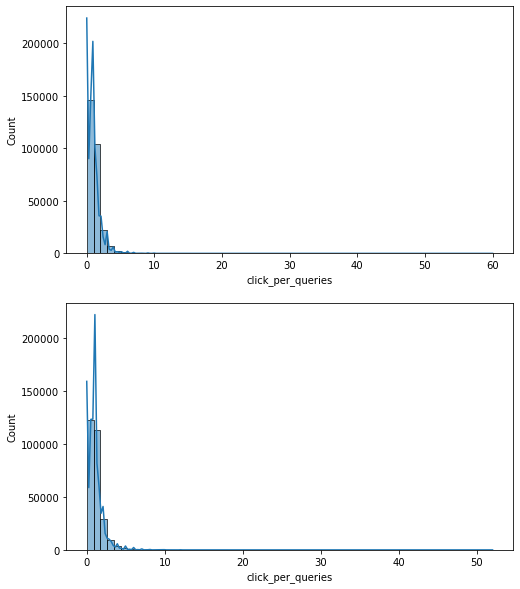

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

sns.histplot(df.loc[df['slot']=='control', 'click_per_queries'], kde=True, ax=ax[0], bins=60)
sns.histplot(df.loc[df['slot']=='exp', 'click_per_queries'], kde=True, ax=ax[1], bins=60)
plt.show()

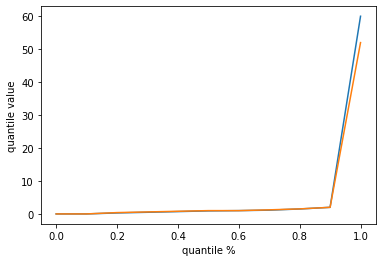

In [51]:
df.loc[df['slot']=='control', 'click_per_queries'].quantile(np.arange(0, 1.1, 0.1)).plot()
df.loc[df['slot']=='exp', 'click_per_queries'].quantile(np.arange(0, 1.1, 0.1)).plot()
plt.xlabel('quantile %')
plt.ylabel('quantile value')
plt.show()

__[10 баллов]__ Скорее всего, в пункте выше вы написали, что $z$-тест нам не подходит из-за выбросов. Однако, мы не можем наверняка знать, насколько серьёзное влияние эти выбросы оказали на ЦПТ и сломали ли они её. Если посчитать по выброкам средние и медианы, они окажутся очень похожими.

Бутстрап — это асимптотическая техника для получения критических значений статистики. Давайте проведём следующую процедуру. Ограничимся в рамках неё контрольной группой. Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстрэп, чтобы понять, как распределена z-статистика и сравнить её распределение с нормальным. 

Поскольку мы знаем, что $\text{Var}(\bar X_n) = \frac{\sigma^2}{n}$, нам не надо будет делать бутстрэп в бутстрэпе. Когда мы знаем для нашей статистики форму дисперсии, бутстрэп называется __параметрическим.__

1. Получите из данных `n_boot_samples` псевдовыборок,
2. По каждой из этих выборок посчитайте среднее и его дисперсию,
3. Рассчитайте значение $z$-статистики,
4. Для получившегося вектора из $z$-статистик постройте `qq-plot` с помощью ` scipy.stats.probplot` для нормального распределения.

Сделайте выводы.

In [4]:
n_boot_samples = 5000

n_control = len(df[df['slot'] == 'control'])

samples = np.random.choice(df.loc[df['slot'] == 'control', 'click_per_queries'], size=(n_boot_samples, n_control))

In [82]:
z_stats = np.array([sample.mean() / (sample.std() / np.sqrt(sample.size)) for sample in samples])

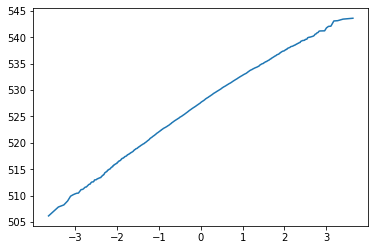

In [77]:
plt.plot(*sts.probplot(z_stats)[0])

__[10 баллов]__ Осторожно, спойлеры! В прошлом пункте у вас получилась картинка, на которой хвосты распределения немного отличаются от стандартного нормального. Давайте сделаем вид, что всё хорошо и отличия на хвостах нет. Проверьте гипотезу о равенстве средних между группами с помощью $z-$теста на уровне значимости $1\%$.

In [5]:
treat = df.loc[df['slot']=='exp', 'click_per_queries'].values
control = df.loc[df['slot']=='control', 'click_per_queries'].values

In [9]:
z_obs = (
    (treat.mean() - control.mean()) 
    / np.sqrt(treat.var(ddof=1) / treat.size + control.var(ddof=1) / control.size)
)

In [139]:
alpha = 0.01
z_crit_left = sts.norm(loc=0, scale=1).ppf(alpha / 2)
z_crit_right = sts.norm(loc=0, scale=1).ppf(1 - alpha / 2)

z_crit_left, z_crit_right

(-2.575829303548901, 2.5758293035489004)

In [111]:
z_obs

27.55706066913807

Наблюдаемое значение статистики очень сильно отклонилось от критических значений на заданном уровне значимости

__[10 баллов]__ Давайте попробуем понять, какими при таких объёмах выборки оказываются MDE и ошибка второго рода. Конечно, же сделать это надо до проведения АБ-теста. Но не мы его готовили... При решении этого пункта выберите какое-то адекватное значение MDE и получите отталкиваясь от него ошибку второго рода.

Формула для расчета числа наблюдений __для одной группы:__

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [119]:
control_mean, exp_mean

(1.0060762464684896, 1.0814744251480255)

In [36]:
def get_beta(mde, alpha=0.01, n_both_groups=len(df)):
    var_control = df.loc[df['slot'] == 'control', 'click_per_queries'].var(ddof=1)
    var_treat = df.loc[df['slot'] == 'exp', 'click_per_queries'].var(ddof=1)
    z_alpha = sts.norm(loc=0, scale=1).ppf(1 - alpha / 2)

    z_beta = np.sqrt(mde ** 2 * n_both_groups / (var_control + var_treat) / 2) - z_alpha
    beta = 1 - sts.norm(loc=0, scale=1).cdf(z_beta)

    return beta

In [37]:
alpha = 0.01
mde = 0.03
n_both_groups = len(df)

print(get_beta(mde, alpha, n_both_groups))

0.0


#### Cлишком хорошо, уменьшу MDE

In [182]:
mde = 0.01
print(get_beta(mde, alpha, n_both_groups))

0.1402254361770604


__[10 баллов]__ Хвосты отличаются от стандартного нормального. По хорошему, для проверки гипотезы нужно использовать бутстрап. В контексте средних, на бутстрап можно смотреть как на технику, которая уточняет, насколько сильно хвосты распределения стали тяжелее по сравнению с ЦПТ. 

Проверьте гипотезу с помощью бутстрапа! Воспользуйтесь следующим алгоритмом с лекции:

1. Посчитайте наблюдаемое значение статистики.
2. Пусть $\bar h$ - это среднее посчитанное по обеим выборкам вместе. Создайте две новые выборки $$x'_i = x_i - \bar x + \bar h \\ y'_i = y_i - \bar y + \bar h.$$ Такое рецентрирование сдвинет обе выборки к общему среднему и  позволит заложить в симуляцию информацию о верности нулевой гипотезы. 
3. Сбутстрапируйте выборки $x^{*}$ и $y^{*}$ из $x'$ и $y'$. Рассчитайте значение z-статистики. Повторит процедуру $B$ раз.
4. Для оценки `p-value` воспользуйтесь формулой:

$$
2 * \frac{1}{B} \sum_{i=1}^B [z_i^{*} \ge z_{obs}]
$$

In [6]:
common_mean = np.hstack([treat, control]).mean()

treat_centered = treat - treat.mean() + common_mean
control_centered = control - control.mean() + common_mean

In [7]:
n_boots = 2000

treat_boots = np.random.choice(treat_centered, (n_boots, treat_centered.size))
control_boots = np.random.choice(control_centered, (n_boots, control_centered.size))

In [18]:
treat_means = treat_boots.mean(axis=1)
control_means = control_boots.mean(axis=1)

In [19]:
treat_vars = treat_boots.var(axis=1, ddof=1)
control_vars = control_boots.var(axis=1, ddof=1)

In [21]:
z_stats = (
    (treat_means - control_means) 
    / np.sqrt(treat_vars / treat.size + control_vars / control.size)
)

#### Посмотрим на распределение статистики на бутстропированных выборках

<AxesSubplot:ylabel='Count'>

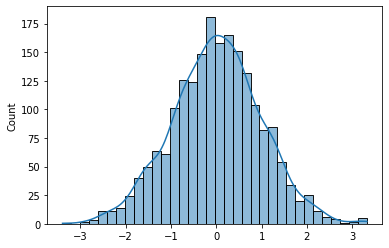

In [26]:
sns.histplot(z_stats, kde=True)

In [33]:
pval = z_stats[z_stats >= z_obs].size * 2 / n_boots
pval

0.0

__Ответьте на следующие вопросы:__

- Изменились ли выводы АБ-теста?
- Насколько сильно критическое значение статистики, полученной с помощью бутстрэпа, отличается от киритческого значения нормального распределения?
- Какую из ошибок (1 рода/2 рода) вы будете чаще совершать, если в ситуации с толстыми хвостами будете пользоваться нормальным распредеелнием? Насколько чаще будет возникать эта ошибка?

In [38]:
z_crit_right = np.quantile(z_stats, 1 - alpha / 2)
z_crit_right

2.5529915277407027

In [40]:
(10000 + 500) * 100

1050000

- Выводы не изменились, изменение значимое
- Слабо отличается, всего на 0.02
- 1 рода, поскольку у нас чаще будут вываливаться значения статистики из толстых хвостов, которые мы будем принимать за экстримальные для нормального распределения. Чем толще хвосты, тем чаще будет совершаться ошибка 1 рода

__[10 баллов]__ Насколько больше наблюдений нам необходимо для проверки гипотезы по сравнению с z-тестом? Для ответа на этот вопрос подставьте критические значение из бустрап-распределения в формулу для оценки числа наблюдений. В качестве MDE возьмите величину, которую вы сами зафикисировали в прошлых пунктах. В качестве ошибки второго рода возьмите получившуюся при рассчётах величину.

In [66]:
var_control = control.var(ddof=1)
var_treat = treat.var(ddof=1)

beta = 0.14
n_one_group = (
    (var_control + var_treat) 
    * (np.quantile(z_stats, 1 - alpha / 2) + np.quantile(z_stats, 1 - beta)) ** 2
    / mde ** 2
)
n_one_group

31006.299459403308

__[10 баллов]__ Проверьте ту же гипотезу тестом Манна-Уитни. Используйте для этого функцию `scipy.stats.mannwhitneyu`.

In [51]:
stat_obs, pval = sts.mannwhitneyu(treat, control)
stat_obs, pval

(37765830709.5, 6.383653996712266e-308)

При $n,m \to \infty$ статистика Манна-Уитни сходится к нормальному распределению со следующими параметрами: 

$$
U \Rightarrow N \left( \frac{n_T \cdot n_C}{2}, \frac{n_T \cdot n_C \cdot (n_T + n_C + 1)}{12} \right)
$$

Отталкиваясь от этого приближения, определите сколько наблюдений нам необходимо для проверки гипотезы для тех же MDE и ошибки 2 рода, что и у z-теста/бустрапа.

Эту часть не делаю, поскольку вопрос некорректен

__[10 баллов]__ У многих аналитиков с теста Манна-Уитни подгорает жепа. Это происходит из-за того, что на практике его часто используют довольно бездумно. [Вот один из свежих примеров бомбежа.](https://habr.com/ru/companies/avito/articles/709596/) 

В нашем кейсе, если аккуратно посчитать квантили обоих распределений, можно увидеть, что в тестовой группе квантили и правда съехали вправо, а форма гистограмм не изменилась. В целом, это знак, что тест можно спокойно применять. Однако, квантили левее $0.1$ не поменялись. 

Вместо тесто Манна-Уитни на сдвиг распределения, мы можем попробовать проверить гипотезу о том, что наше распределение, в принципе, как-то поменялось. Для таких гипотез обычно используются критерии согласия. Проверьте гипотезу о том, что распределения тестовой и контрольной групп совпадают с помощью теста Колмогорова-Смирнова `scipy.stats.ks_2sam`.

In [67]:
stat_obs, pval = sts.ks_2samp(treat, control)
stat_obs, pval

(0.04512279635017363, 1.0120907577765547e-250)

Насколько сильно друг от друга отличаются p-значения этих тестов? Как думаете, почему отличие именно такое?

__Ответ:__

pval теста Манна-Уитни гораздо ниже, пока не понял почему

## Часть 2: CUPED

Попробуем натянуть сову на глобус. Давайте сделаем вид, что на самом деле первые $50\%$ таблицы это выборка, которая у нас была до эксперимента. Попробуем провернуть CUPED. 

__[10 баллов]__ рассчитайте значение стандартной ошибки для $z$-статистики по второй части выборки. С помощью CUPED мы будем пытаться уменьшить значение этой ошибки.

In [70]:
treshold = len(df) // 2
before = df[:treshold]
test = df[treshold:]

treat = test.loc[test['slot']=='exp', 'click_per_queries'].values
control = test.loc[test['slot']=='control', 'click_per_queries'].values

In [72]:
se = np.sqrt(treat.var(ddof=1) / treat.size + control.var(ddof=1) / control.size)
se

0.0044424060716190955

__[20 баллов]__ теперь проверните CUPED. Используйте значение целевой переменной из первой части выборки как ковариату.

Для оценки линейных моделей используйте пакет `statsmodels`. Пример того, как это можно делать [есть тут.](https://github.com/FUlyankin/matstat-AB/blob/main/week13_linreg/11_python_regression.ipynb) Предполагайте, что в данных есть гетероскедастичность. Для её фикса пользуйтесь `HC-3`.

Насколько у нас получилось уменьшить стандартную ошибку?

In [73]:
import statsmodels.formula.api as smf

In [86]:
before.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19,0.718750,0.593750
1,3,Browser #4,exp,3,4,2,0.750000,0.500000
2,5,Browser #4,exp,29,35,16,0.828571,0.457143
3,6,Browser #4,control,12,6,0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30,0.794118,0.441176


In [92]:
model_first = smf.ols('click_per_queries ~ empty_query_share', data=before)
res_first = model_first.fit(cov_type='HC3')
print(res_first.summary())

                            OLS Regression Results                            
Dep. Variable:      click_per_queries   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                 1.182e+05
Date:                Sat, 17 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:07:57   Log-Likelihood:            -2.8918e+05
No. Observations:              283067   AIC:                         5.784e+05
Df Residuals:                  283065   BIC:                         5.784e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.8576      0.00

In [97]:
test['residual'] = test['click_per_queries'] - res_first.params.empty_query_share * test['empty_query_share']

<ipython-input-97-d367f8fe389a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = test['click_per_queries'] - res_first.params.empty_query_share * test['empty_query_share']


In [98]:
test['treat'] = (test['slot'] == 'exp').astype(int)

<ipython-input-98-2b13d0080658>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['treat'] = (test['slot'] == 'exp').astype(int)


In [99]:
model = smf.ols('residual ~ treat', data=test)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               residual   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     11.52
Date:                Sat, 17 Jun 2023   Prob (F-statistic):           0.000688
Time:                        14:12:03   Log-Likelihood:            -3.8743e+05
No. Observations:              283067   AIC:                         7.749e+05
Df Residuals:                  283065   BIC:                         7.749e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8653      0.002    760.452      0.0

In [108]:
res.bse.treat

0.0035761667570918055

In [112]:
print(f'Ранее ошибка была \n{se:.5f},\nПолучилось уменьшить ее')

Ранее ошибка была 
0.00444,
Получилось уменьшить ее


__[20 баллов]__ Ровно по той же схеме проверните CUPAC. В качестве базовой модели возьмите какой-нибудь градиентный бустинг. Насколько у нас получилось уменьшить стандартную ошибку? 

In [119]:
from catboost import CatBoostRegressor

gbm_model = CatBoostRegressor(cat_features=['browser'])
gbm_model.fit(before[['browser', 'empty_query_share']], before['click_per_queries'], silent=True)

test['gbm_pred'] = gbm_model.predict(test[['browser', 'empty_query_share']])
test.loc[test['gbm_pred'] < 0, 'gbm_pred'] = 0

In [122]:
model_first = smf.ols('click_per_queries ~ gbm_pred', data=test) #'residual ~ treat + gbm_pred'
res = model_first.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      click_per_queries   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 1.368e+05
Date:                Sat, 17 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:45:57   Log-Likelihood:            -3.8689e+05
No. Observations:              283067   AIC:                         7.738e+05
Df Residuals:                  283065   BIC:                         7.738e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0036      0.001      2.536      0.0

In [123]:
test['residual'] = test['click_per_queries'] - res.params.gbm_pred * test['gbm_pred']

<ipython-input-123-fa7521f73cbd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = test['click_per_queries'] - res.params.gbm_pred * test['gbm_pred']


In [125]:
model = smf.ols('residual ~ treat', data=test)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               residual   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     16.24
Date:                Sat, 17 Jun 2023   Prob (F-statistic):           5.57e-05
Time:                        14:48:53   Log-Likelihood:            -3.8689e+05
No. Observations:              283067   AIC:                         7.738e+05
Df Residuals:                  283065   BIC:                         7.738e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0035      0.002     -1.432      0.1

In [127]:
res.bse.treat

0.0035693091633780816

Еще немного уменьшилась ошибка

__[10 баллов]__ Финальный вопрос! А как использовать эту новую стандартную ошибку в формуле для рассчёта числа наблюдений? Выясните при выбранном выми MDE, какая у нас будет ошибка второго рода в CUPED и CUPAC, если в АБ-тесте будет участвовать только половина наблюдений.

In [147]:
cov = np.cov(test['click_per_queries'], test['empty_query_share'])[0, 1]
var = test['empty_query_share'].var()
theta = cov / var

theta

-1.8708063959931995

In [141]:
metric_cuped = test['click_per_queries'] - theta * (test['empty_query_share'] - test['empty_query_share'].mean())

In [143]:
test['metric_cuped'] = metric_cuped

<ipython-input-143-a15627cba777>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['metric_cuped'] = metric_cuped


In [145]:
def get_beta(mde, alpha=0.01, n_both_groups=len(test)):
    var_control = test.loc[test['slot'] == 'control', 'metric_cuped'].var(ddof=1)
    var_treat = test.loc[test['slot'] == 'exp', 'metric_cuped'].var(ddof=1)
    z_alpha = sts.norm(loc=0, scale=1).ppf(1 - alpha / 2)

    z_beta = np.sqrt(mde ** 2 * n_both_groups / (var_control + var_treat) / 2) - z_alpha
    beta = 1 - sts.norm(loc=0, scale=1).cdf(z_beta)

    return beta

In [149]:
mde

0.03

In [146]:
get_beta(mde)

3.0364437630936436e-09

Значение намного меньше, ранее было 0.14, но я не уверен, что правильно это сделал, когда считал дисперсию новой метрики и подставлял в формулу